# Fourier Series Using Blosc2
Fourier series can be used to approximate real signals (i.e. response values at times defined by a vector `t`) by decomposing them into `n` trigonometric components:
$$
\text{signal}(t) \approx \sum_{i=1}^{n} a_i\cos(t) + b_i\sin(t).
$$
We can use this technique to approximate the following square wave. This notebook was inspired by [this blog](https://towardsdatascience.com/numexpr-the-faster-than-numpy-library-that-no-ones-heard-of/).

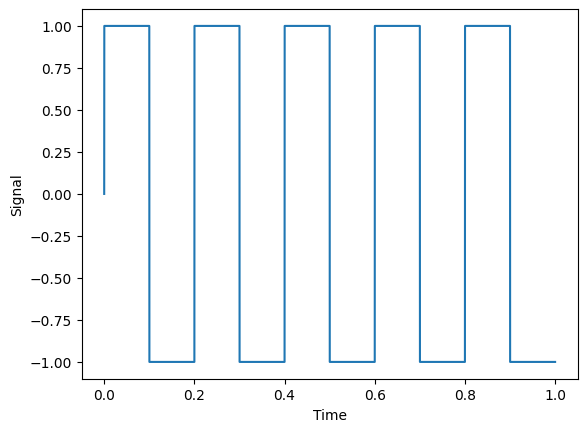

In [15]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

import blosc2

tot_time = 2**20
# Generate a time vector and a square wave signal
t = blosc2.linspace(0, 1, tot_time, shape=(tot_time, 1), urlpath="t.b2nd", mode="w")
signal = blosc2.sign(blosc2.sin(2 * blosc2.pi * 5 * t))

fig, ax = plt.subplots()

# Plotting the results
ax.plot(t[:], signal[:], label="Signal")
ax.set_xlabel("Time")
ax.set_ylabel("Signal")
plt.show()


A concise way to implement the summation is ``sum(a * cos(t) + b * sin(t), axis=1)``, where `a, b` are vectors of shape `(n,)` and `t` has shape `(max_time, 1)`, since broadcasting massages the expression into `(max_time, n)`, which when summed returns the approximated signal of the same length as `t`. However, this broadcasting can rapidly saturate memory if using NumPy, as we shall now see.

We'll compare NumPy computation times with the hyper-memory-efficient Blosc2 library. In fact, Blosc2 is so fast we can store the operands on disk, fetch them in chunks iteratively, and compute with them, all faster than NumPy can sum them in-memory!

In [16]:
f_temp = [500, 1000, 2000, 3000, 4000, 5000]

blosc2_wset = []
numpy_wset = []

npt = t[:]
blosc2_times = []
numpy_times = []

for n_terms in f_temp:
    # Number of terms in the Fourier series
    n = blosc2.arange(1, n_terms + 1, 2, urlpath="n.b2nd", mode="w")

    # Memory consumption
    result_shape = np.broadcast_shapes(t.shape, n.shape)

    chunks = blosc2.empty(result_shape, dtype=t.dtype).chunks
    working_set = np.prod(chunks) * t.dtype.itemsize
    blosc2_wset += [working_set / 2**30]

    working_set = np.prod(result_shape) * t.dtype.itemsize
    numpy_wset += [working_set / 2**30]

    # Fourier series approximation using Blosc2
    start_time = time.time()
    approx_blosc2 = blosc2.sum((4 / (blosc2.pi * n)) * blosc2.sin(2 * blosc2.pi * n * 5 * t), axis=1)
    blosc2_times += [time.time() - start_time]

    # Fourier series approximation using NumPy
    n = n[:]
    start_time = time.time()
    approx_np = np.sum((4 / (np.pi * n)) * np.sin(2 * np.pi * n * 5 * npt), axis=1)
    numpy_times += [time.time() - start_time]

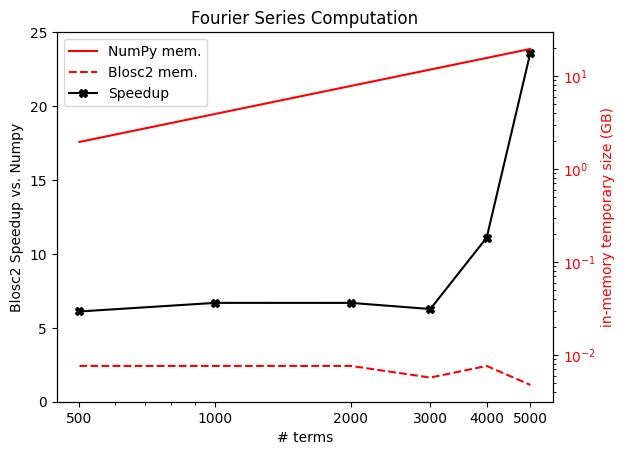

In [19]:
## Plot results
fig, ax = plt.subplots()
ax.semilogx(
    f_temp, np.array(numpy_times) / np.array(blosc2_times), label="Speedup", base=10, color="k", marker="X"
)
ax.set_ylabel("Blosc2 Speedup vs. Numpy", color="k")
ax.tick_params(axis="y", labelcolor="k")

ax_ = ax.twinx()
ax_.loglog(f_temp, numpy_wset, label="NumPy mem.", color="r", ls="-")
ax_.loglog(f_temp, blosc2_wset, label="Blosc2 mem.", base=10, color="r", ls="--")
ax_.plot([], [], label="Speedup", color="k", marker="X")
ax_.set_ylabel("in-memory temporary size (GB)", color="r")
ax_.tick_params(axis="y", labelcolor="r")
ax_.legend()

ax.set_xlabel("# terms")
ax.set_title("Fourier Series Computation")
ax.set_xticks([500, 1000, 2000, 3000, 4000, 5000])
ax.set_ylim([0, 25])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.show()

#### Analysis
Clearly, NumPy becomes increasingly slow relative to Blosc2 as memory constraints start to bite - indicated by the uptick for the NumPy calculation for larger numbers of terms. One way around this is to use a `for` loop
```
approx_np = np.zeros_like(t)
for i in range(n):
    approx_np += a[i] * cos(t) + b[i] * sin(t)
```
which avoids the costly in-memory temporaries created by broadcasting. This is typically faster when using NumPy on larger arrays. We'll use this approach for a more complete comparison (only for execution time).

Note that Blosc2's chunked approach uses essentially constant in-memory temporaries (automatically optimised for your device's cache size) even as the total sizes of the full operands grow - this is what allows it to have constant scaling of execution time even as the operand sizes increase! 

In [20]:
blosc2_times = []
numpy_times = []
signal = signal[:]
nperr = []
bloscerr = []
fseries_terms = [250, 500, 1000, 2000, 4000, 8000, 16000]

for n_terms in fseries_terms:
    # Number of terms in the Fourier series
    n = blosc2.arange(1, n_terms + 1, 2, urlpath="n.b2nd", mode="w")

    # Fourier series approximation using Blosc2
    start_time = time.time()
    approx_blosc2 = blosc2.sum(
        (4 / (blosc2.pi * n)) * blosc2.sin(2 * blosc2.pi * n * 5 * t), axis=1, keepdims=True
    )
    blosc2_times += [time.time() - start_time]

    # Fourier series approximation using NumPy
    start_time = time.time()
    approx_np = np.zeros_like(npt)
    for n_ in range(1, n_terms + 1, 2):
        approx_np += (4 / (np.pi * n_)) * np.sin(2 * np.pi * n_ * 5 * npt)
    numpy_times += [time.time() - start_time]

    # Check NumPy and Blosc2 approximations are (almost) equal
    np.testing.assert_allclose(approx_np, approx_blosc2)

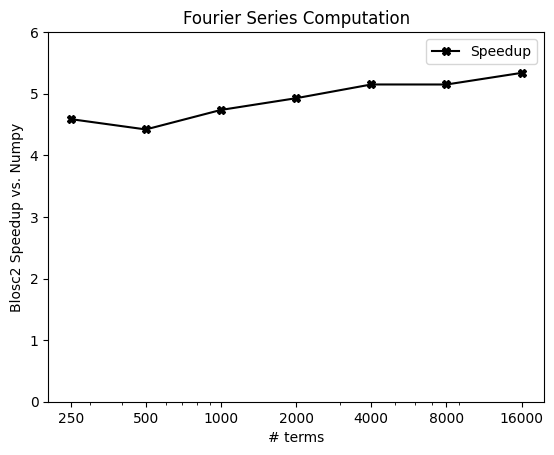

In [23]:
## Plot results
fig, ax = plt.subplots()

ax.semilogx(
    fseries_terms,
    np.array(numpy_times) / np.array(blosc2_times),
    base=10,
    color="k",
    marker="X",
    label="Speedup",
)
ax.set_ylabel("Blosc2 Speedup vs. Numpy")
ax.set_ylim([0, 6])
ax.set_xticks([250, 500, 1000, 2000, 4000, 8000, 16000])
ax.set_title("Fourier Series Computation")
ax.set_xlabel("# terms")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend()

## Conclusion
Blosc2 remains 5x faster than NumPy even when using a memory-optimised approach for the latter, and moreover preserves the more intuitive, concise and pythonic ``sum`` syntax. In the last cell we checked that Numpy and Blosc2 give approximations which are the same (up to rounding errors), and we can also see that NumPy and Blosc2 approximate the square wave below. By using compressed, chunked arrays which can be fetched rapidly from disk, combined with the hyper-fast compiled-code library `numexpr` behind the scenes, Blosc2 can accelerate your (data-)scientific computations!

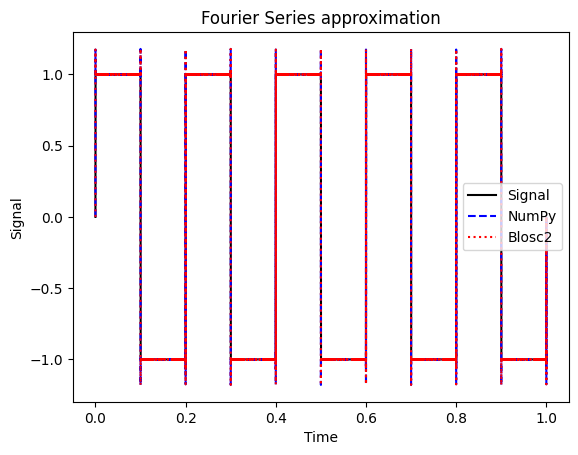

In [22]:
fig, ax = plt.subplots()

# Plotting the results
t = t[:]
ax.plot(t, signal[:], label="Signal", color="k")
ax.plot(t, approx_np, label="NumPy", color="b", ls="--")
ax.plot(t, approx_blosc2, label="Blosc2", color="r", ls=":")
ax.legend()
ax.set_title("Fourier Series approximation")
ax.set_xlabel("Time")
ax.set_ylabel("Signal")
plt.show()